# data_feature_engineering3

2017-05-19

In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime,timedelta,date,time
import matplotlib.pyplot as plt
%matplotlib inline
import copy

### 录入数据

In [18]:
travel_time_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/train_20min_avg_travel_time.csv')
volume_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/train_20min_avg_volume.csv')
weather_data = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/原始数据/weather_train.csv')

test_travel_time_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/test_20min_avg_travel_time.csv')
test_volume_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/test_20min_avg_volume.csv')
test_weather_data = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/原始数据/weather_test.csv')

### 初步清洗数据

In [19]:
# 异常样本删除（最大的1%的平均时间的样本删除）
def ff(df):
    df = df.sort(['avg_travel_time'], ascending=False)
    num_sample = len(df)
    num_delete = round(0.01 * num_sample)
    temp_df = df.iloc[num_delete:]
    return temp_df

def ff2(df):
    df = df.sort(['volume'], ascending=False)
    num_sample = len(df)
    num_delete = round(0.01 * num_sample)
    temp_df = df.iloc[num_delete:]
    return temp_df

travel_time_window = travel_time_window.groupby(['intersection_id', 'tollgate_id']).apply(ff)

volume_window = volume_window.groupby(['tollgate_id', 'direction']).apply(ff2)

/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### 9.19后全时段数据

In [20]:
# 先形成全时段数据
time_full_time = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/pyscripts/analyze/full_time1.csv')
volume_full_time = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/pyscripts/analyze/full_time2.csv')

travel_time_window = pd.merge(time_full_time, travel_time_window, on=['intersection_id','tollgate_id','time_window'], how='left')
volume_window = pd.merge(volume_full_time, volume_window, on=['tollgate_id','direction','time_window'], how='left')

In [21]:
# 添加是否为原始真实数据的标志
travel_time_window['is_true'] = travel_time_window['avg_travel_time'].map(lambda x: x>0)
volume_window['is_true'] = volume_window['volume'].map(lambda x: x>0)

In [15]:
print(len(travel_time_window[travel_time_window['avg_travel_time'].isnull()]))
print(len(travel_time_window))

4120
15552


In [16]:
print(len(volume_window[volume_window['volume'].isnull()]))
print(len(volume_window))

578
12960


### 补充特征

In [23]:
# 整合平均时间与天气数据
travel_time_window['start_time'] = travel_time_window['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
weather_data['date'] = weather_data['date'].astype(str)
weather_data['hour'] = weather_data['hour'].map(lambda x: ' ' + time(x, 0, 0).strftime('%H:%M:%S'))
weather_data['start_time'] = weather_data['date'] + weather_data['hour']
weather_data['start_time'] = weather_data['start_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
del weather_data['date']
del weather_data['hour']
num = len(weather_data)
for i in range(num):
    temp = weather_data.ix[i]
    temp1 = copy.deepcopy(temp)
    temp2 = copy.deepcopy(temp)
    temp3 = copy.deepcopy(temp)
    temp4 = copy.deepcopy(temp)
    temp5 = copy.deepcopy(temp)
    temp6 = copy.deepcopy(temp)
    temp7 = copy.deepcopy(temp)
    temp8 = copy.deepcopy(temp)
    stime = temp.start_time
    temp1.start_time = stime + timedelta(minutes=20)
    temp2.start_time = stime + timedelta(minutes=40)
    temp3.start_time = stime + timedelta(minutes=60)
    temp4.start_time = stime + timedelta(minutes=80)
    temp5.start_time = stime + timedelta(minutes=100)
    temp6.start_time = stime + timedelta(minutes=120)
    temp7.start_time = stime + timedelta(minutes=140)
    temp8.start_time = stime + timedelta(minutes=160)
    alltemp = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
    alltemp = pd.DataFrame(alltemp)
    weather_data = pd.concat([weather_data, alltemp])
# 合并
travel_time_window = pd.merge(travel_time_window, weather_data, on='start_time', how='left')
travel_time_window['time'] = travel_time_window['start_time'].map(lambda x: x.time())
travel_time_window['date'] = travel_time_window['start_time'].map(lambda x: x.date())

# 整合流量与天气数据
volume_window['start_time'] = volume_window['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:],'%Y-%m-%d %H:%M:%S'))
volume_window['pair'] = volume_window['tollgate_id'].astype(str) + '-' + volume_window['direction'].astype(str)
volume_window = pd.merge(volume_window, weather_data, on='start_time', how='left')

In [24]:
# 增加路线和星期几，小时，分钟
travel_time_window['weekday'] = travel_time_window['start_time'].map(lambda x: x.weekday())
travel_time_window['hour'] = travel_time_window['start_time'].map(lambda x: x.hour)
travel_time_window['minute'] = travel_time_window['start_time'].map(lambda x: x.minute)
travel_time_window['route'] = travel_time_window['intersection_id'].astype(str) + '-' + travel_time_window['tollgate_id'].astype(str)

# 增加星期几和时间窗口两列
volume_window['date'] = volume_window['start_time'].map(lambda x: x.date())
volume_window['weekday'] = volume_window['start_time'].map(lambda x: x.weekday())
volume_window['time'] = volume_window['start_time'].map(lambda x: x.time())
volume_window['hour'] = volume_window['start_time'].map(lambda x: x.hour)
volume_window['minute'] = volume_window['start_time'].map(lambda x: x.minute)

In [25]:
# 增加月份和几号
travel_time_window['month'] = travel_time_window['date'].map(lambda x: x.month)
travel_time_window['day'] = travel_time_window['date'].map(lambda x: x.day)

volume_window['month'] = volume_window['date'].map(lambda x: x.month)
volume_window['day'] = volume_window['date'].map(lambda x: x.day)

In [26]:
# 把time映射成1～72
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
travel_time_window['timemap'] = travel_time_window['time'].map(lambda x:timedic[x])

# 时间映射成1～72
volume_window['timemap'] = volume_window['time'].map(lambda x:timedic[x])

In [27]:
# 增加法定节假日特征
#holiday = ['2016-09-15','2016-09-16','2016-09-17','2016-10-01','2016-10-02','2016-10-03','2016-10-04','2016-10-05','2016-10-06','2016-10-07']
holiday = [date(2016,9,15),date(2016,9,16),date(2016,9,17),date(2016,10,1),date(2016,10,2),date(2016,10,3),date(2016,10,4),date(2016,10,5),date(2016,10,6),date(2016,10,7)]

def ff(x):
    if x in holiday:
        return 1
    else:
        return 0
travel_time_window['holiday'] = travel_time_window['date'].map(ff)

volume_window['holiday'] = volume_window['date'].map(ff)

### 排序

In [28]:
time_columns = ['avg_travel_time', 'is_true', 
                'route', 'intersection_id', 'tollgate_id', 
                'time_window', 'start_time', 
                'date', 'month', 'day', 'weekday', 'holiday',
                'time', 'hour', 'minute', 'timemap',
                'pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 
                 ]

volume_columns = ['volume', 'is_true',
                  'pair', 'tollgate_id', 'direction',
                  'time_window', 'start_time',
                  'date', 'month', 'day', 'weekday', 'holiday',
                  'time', 'hour', 'minute', 'timemap',
                  'pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 
                  ]

travel_time_window = travel_time_window[time_columns]
volume_window = volume_window[volume_columns]

travel_time_window = travel_time_window.sort_values(by=['route', 'start_time'])
travel_time_window.index = np.arange(len(travel_time_window))

volume_window = volume_window.sort_values(by=['pair', 'start_time'])
volume_window.index = np.arange(len(volume_window))

### 清洗数据

In [29]:
# 风向异常值处理，以最近的风向值代替
wind_direction = travel_time_window['wind_direction']
wind_direction[wind_direction > 360] = np.nan
wind_direction.fillna(method='ffill', inplace=True)

wind_direction = volume_window['wind_direction']
wind_direction[wind_direction > 360] = np.nan
wind_direction.fillna(method='ffill', inplace=True)

/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
# 流量节假日数据清除
volume_window = volume_window[volume_window['holiday'] == 0]

### xgboost补充9.19之后的缺失值

In [31]:
travel_time_window = travel_time_window.sort_values(by=['route','start_time'])
travel_time_window.index = np.arange(len(travel_time_window))
volume_window = volume_window.sort_values(by=['pair','start_time'])
volume_window.index = np.arange(len(volume_window))

In [32]:
# 分割训练集和测试集
time_train_data = travel_time_window.loc[travel_time_window['avg_travel_time'].notnull()]
time_test_data = travel_time_window.loc[travel_time_window['avg_travel_time'].isnull()]

volume_train_data = volume_window.loc[volume_window['volume'].notnull()]
volume_test_data = volume_window.loc[volume_window['volume'].isnull()]

In [33]:
temp_time_train = time_train_data[['avg_travel_time', 'route', 
                                   'month', 'day', 'weekday', 'holiday', 'timemap', 
                                   'pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation']]
temp_time_test = time_test_data[['route', 
                                 'month', 'day', 'weekday', 'holiday', 'timemap', 
                                 'pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation']]
temp_volume_train = volume_train_data[['volume', 'pair', 
                                       'month', 'day', 'weekday', 'holiday', 'timemap', 
                                       'pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation']]
temp_volume_test = volume_test_data[['pair', 
                                     'month', 'day', 'weekday', 'holiday', 'timemap', 
                                     'pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation']]

In [34]:
# 分割路径，对
A2_train = temp_time_train[temp_time_train['route'] == 'A-2']
A3_train = temp_time_train[temp_time_train['route'] == 'A-3']
B1_train = temp_time_train[temp_time_train['route'] == 'B-1']
B3_train = temp_time_train[temp_time_train['route'] == 'B-3']
C1_train = temp_time_train[temp_time_train['route'] == 'C-1']
C3_train = temp_time_train[temp_time_train['route'] == 'C-3']

A2_test = temp_time_test[temp_time_test['route'] == 'A-2']
A3_test = temp_time_test[temp_time_test['route'] == 'A-3']
B1_test = temp_time_test[temp_time_test['route'] == 'B-1']
B3_test = temp_time_test[temp_time_test['route'] == 'B-3']
C1_test = temp_time_test[temp_time_test['route'] == 'C-1']
C3_test = temp_time_test[temp_time_test['route'] == 'C-3']

V10_train =  temp_volume_train[temp_volume_train['pair'] == '1-0']
V11_train =  temp_volume_train[temp_volume_train['pair'] == '1-1']
V20_train =  temp_volume_train[temp_volume_train['pair'] == '2-0']
V30_train =  temp_volume_train[temp_volume_train['pair'] == '3-0']
V31_train =  temp_volume_train[temp_volume_train['pair'] == '3-1']

V10_test =  temp_volume_test[temp_volume_test['pair'] == '1-0']
V11_test =  temp_volume_test[temp_volume_test['pair'] == '1-1']
V20_test =  temp_volume_test[temp_volume_test['pair'] == '2-0']
V30_test =  temp_volume_test[temp_volume_test['pair'] == '3-0']
V31_test =  temp_volume_test[temp_volume_test['pair'] == '3-1']

In [35]:
del A2_train['route']
del A3_train['route']
del B1_train['route']
del B3_train['route']
del C1_train['route']
del C3_train['route']

del A2_test['route']
del A3_test['route']
del B1_test['route']
del B3_test['route']
del C1_test['route']
del C3_test['route']

del V10_train['pair']
del V11_train['pair']
del V20_train['pair']
del V30_train['pair']
del V31_train['pair']

del V10_test['pair']
del V11_test['pair']
del V20_test['pair']
del V30_test['pair']
del V31_test['pair']

In [36]:
# 自定义评价函数
def MAPE(preds, dtrain):
    labels = dtrain.get_label()
    return 'MAPE', float(sum(np.fabs((labels - preds) / labels))) / len(labels)

#### A2

In [37]:
## 训练预测
# 分割训练集和验证集
ll = round(len(A2_train)/5)
A2_train_val = A2_train.iloc[(len(A2_train)-ll):len(A2_train)]
A2_train_t = A2_train.iloc[:(len(A2_train)-ll)]

# 分离标签和特征
Y_time = A2_train_t['avg_travel_time']
X_time = A2_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = A2_train_val.avg_travel_time
val_X_time = A2_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(A2_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 64
watchlist = [(time_train, 'train'), (time_val, 'val')]

A2time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", A2time_model.best_ntree_limit)

A2time_predict = A2time_model.predict(time_test)

[0]	train-rmse:61.9097	val-rmse:62.4934	train-MAPE:0.949235	val-MAPE:0.949509
[1]	train-rmse:59.6179	val-rmse:60.108	train-MAPE:0.908914	val-MAPE:0.909107
[2]	train-rmse:57.4239	val-rmse:57.8218	train-MAPE:0.870236	val-MAPE:0.870287
[3]	train-rmse:55.3239	val-rmse:55.6062	train-MAPE:0.833061	val-MAPE:0.832591
[4]	train-rmse:53.3142	val-rmse:53.5107	train-MAPE:0.797446	val-MAPE:0.796803
[5]	train-rmse:51.3901	val-rmse:51.4837	train-MAPE:0.763616	val-MAPE:0.762116
[6]	train-rmse:49.5496	val-rmse:49.5703	train-MAPE:0.731252	val-MAPE:0.729235
[7]	train-rmse:47.7885	val-rmse:47.734	train-MAPE:0.700107	val-MAPE:0.697455
[8]	train-rmse:46.1067	val-rmse:45.963	train-MAPE:0.670424	val-MAPE:0.666779
[9]	train-rmse:44.4971	val-rmse:44.2725	train-MAPE:0.642056	val-MAPE:0.637387
[10]	train-rmse:42.9568	val-rmse:42.6712	train-MAPE:0.614778	val-MAPE:0.609534
[11]	train-rmse:41.4859	val-rmse:41.103	train-MAPE:0.588678	val-MAPE:0.582413
[12]	train-rmse:40.0761	val-rmse:39.6238	train-MAPE:0.563805	val-M

#### A3

In [38]:
## 训练预测
# 分割训练集和验证集
ll = round(len(A3_train)/5)
A3_train_val = A3_train.iloc[(len(A3_train)-ll):len(A3_train)]
A3_train_t = A3_train.iloc[:(len(A3_train)-ll)]

# 分离标签和特征
Y_time = A3_train_t['avg_travel_time']
X_time = A3_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = A3_train_val.avg_travel_time
val_X_time = A3_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(A3_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 69
watchlist = [(time_train, 'train'), (time_val, 'val')]

A3time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", A3time_model.best_ntree_limit)

A3time_predict = A3time_model.predict(time_test)

[0]	train-rmse:112.666	val-rmse:121.91	train-MAPE:0.9533	val-MAPE:0.955079
[1]	train-rmse:108.495	val-rmse:117.651	train-MAPE:0.913122	val-MAPE:0.916392
[2]	train-rmse:104.492	val-rmse:113.608	train-MAPE:0.874737	val-MAPE:0.879921
[3]	train-rmse:100.661	val-rmse:109.718	train-MAPE:0.837822	val-MAPE:0.844546
[4]	train-rmse:96.9958	val-rmse:105.986	train-MAPE:0.802435	val-MAPE:0.810416
[5]	train-rmse:93.48	val-rmse:102.406	train-MAPE:0.768462	val-MAPE:0.777756
[6]	train-rmse:90.1153	val-rmse:98.9807	train-MAPE:0.735983	val-MAPE:0.74639
[7]	train-rmse:86.8974	val-rmse:95.737	train-MAPE:0.70499	val-MAPE:0.716382
[8]	train-rmse:83.8197	val-rmse:92.6265	train-MAPE:0.67561	val-MAPE:0.687545
[9]	train-rmse:80.8587	val-rmse:89.5524	train-MAPE:0.647588	val-MAPE:0.659293
[10]	train-rmse:78.0275	val-rmse:86.6077	train-MAPE:0.62073	val-MAPE:0.632077
[11]	train-rmse:75.3266	val-rmse:83.9033	train-MAPE:0.594974	val-MAPE:0.606752
[12]	train-rmse:72.7507	val-rmse:81.2807	train-MAPE:0.570166	val-MAPE:0.

#### B1

In [39]:
## 训练预测
# 分割训练集和验证集
ll = round(len(B1_train)/5)
B1_train_val = B1_train.iloc[(len(B1_train)-ll):len(B1_train)]
B1_train_t = B1_train.iloc[:(len(B1_train)-ll)]

# 分离标签和特征
Y_time = B1_train_t['avg_travel_time']
X_time = B1_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = B1_train_val.avg_travel_time
val_X_time = B1_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(B1_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 55
watchlist = [(time_train, 'train'), (time_val, 'val')]

B1time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", B1time_model.best_ntree_limit)

B1time_predict = B1time_model.predict(time_test)

[0]	train-rmse:119.562	val-rmse:118.646	train-MAPE:0.953817	val-MAPE:0.951675
[1]	train-rmse:115.088	val-rmse:114.019	train-MAPE:0.913771	val-MAPE:0.909848
[2]	train-rmse:110.806	val-rmse:109.574	train-MAPE:0.875314	val-MAPE:0.869457
[3]	train-rmse:106.704	val-rmse:105.335	train-MAPE:0.838467	val-MAPE:0.830946
[4]	train-rmse:102.774	val-rmse:101.278	train-MAPE:0.803156	val-MAPE:0.794431
[5]	train-rmse:99.0138	val-rmse:97.3683	train-MAPE:0.769317	val-MAPE:0.759949
[6]	train-rmse:95.4146	val-rmse:93.6363	train-MAPE:0.736753	val-MAPE:0.726654
[7]	train-rmse:91.9689	val-rmse:90.1231	train-MAPE:0.705565	val-MAPE:0.695219
[8]	train-rmse:88.6714	val-rmse:86.6842	train-MAPE:0.67558	val-MAPE:0.664526
[9]	train-rmse:85.5164	val-rmse:83.4572	train-MAPE:0.646932	val-MAPE:0.635396
[10]	train-rmse:82.4981	val-rmse:80.3335	train-MAPE:0.619372	val-MAPE:0.607289
[11]	train-rmse:79.612	val-rmse:77.43	train-MAPE:0.593083	val-MAPE:0.580878
[12]	train-rmse:76.8579	val-rmse:74.606	train-MAPE:0.567791	val-MA

#### B3

In [40]:
## 训练预测
# 分割训练集和验证集
ll = round(len(B3_train)/5)
B3_train_val = B3_train.iloc[(len(B3_train)-ll):len(B3_train)]
B3_train_t = B3_train.iloc[:(len(B3_train)-ll)]

# 分离标签和特征
Y_time = B3_train_t['avg_travel_time']
X_time = B3_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = B3_train_val.avg_travel_time
val_X_time = B3_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(B3_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 43
watchlist = [(time_train, 'train'), (time_val, 'val')]

B3time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", B3time_model.best_ntree_limit)

B3time_predict = B3time_model.predict(time_test)

[0]	train-rmse:97.2346	val-rmse:94.1172	train-MAPE:0.951823	val-MAPE:0.949889
[1]	train-rmse:93.6157	val-rmse:90.4467	train-MAPE:0.910873	val-MAPE:0.907531
[2]	train-rmse:90.1489	val-rmse:86.9241	train-MAPE:0.871565	val-MAPE:0.866789
[3]	train-rmse:86.8299	val-rmse:83.5517	train-MAPE:0.83402	val-MAPE:0.827671
[4]	train-rmse:83.654	val-rmse:80.29	train-MAPE:0.798317	val-MAPE:0.789738
[5]	train-rmse:80.6132	val-rmse:77.2702	train-MAPE:0.764597	val-MAPE:0.754633
[6]	train-rmse:77.7044	val-rmse:74.3305	train-MAPE:0.732145	val-MAPE:0.720555
[7]	train-rmse:74.9199	val-rmse:71.5319	train-MAPE:0.701344	val-MAPE:0.688421
[8]	train-rmse:72.2569	val-rmse:68.8374	train-MAPE:0.671723	val-MAPE:0.65748
[9]	train-rmse:69.7105	val-rmse:66.2091	train-MAPE:0.643487	val-MAPE:0.627496
[10]	train-rmse:67.2742	val-rmse:63.7823	train-MAPE:0.616506	val-MAPE:0.599884
[11]	train-rmse:64.9466	val-rmse:61.4447	train-MAPE:0.590691	val-MAPE:0.573183
[12]	train-rmse:62.7236	val-rmse:59.1814	train-MAPE:0.566092	val-MA

#### C1

In [41]:
## 训练预测
# 分割训练集和验证集
ll = round(len(C1_train)/5)
C1_train_val = C1_train.iloc[(len(C1_train)-ll):len(C1_train)]
C1_train_t = C1_train.iloc[:(len(C1_train)-ll)]

# 分离标签和特征
Y_time = C1_train_t['avg_travel_time']
X_time = C1_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = C1_train_val.avg_travel_time
val_X_time = C1_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(C1_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 68
watchlist = [(time_train, 'train'), (time_val, 'val')]

C1time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", C1time_model.best_ntree_limit)

C1time_predict = C1time_model.predict(time_test)

[0]	train-rmse:177.108	val-rmse:181.519	train-MAPE:0.955622	val-MAPE:0.956611
[1]	train-rmse:170.429	val-rmse:174.666	train-MAPE:0.915959	val-MAPE:0.917054
[2]	train-rmse:164.03	val-rmse:168.058	train-MAPE:0.8778	val-MAPE:0.878809
[3]	train-rmse:157.898	val-rmse:161.723	train-MAPE:0.841308	val-MAPE:0.84203
[4]	train-rmse:152.024	val-rmse:155.673	train-MAPE:0.80623	val-MAPE:0.806718
[5]	train-rmse:146.392	val-rmse:149.822	train-MAPE:0.772643	val-MAPE:0.772813
[6]	train-rmse:140.997	val-rmse:143.993	train-MAPE:0.740375	val-MAPE:0.738875
[7]	train-rmse:135.833	val-rmse:138.422	train-MAPE:0.709352	val-MAPE:0.706068
[8]	train-rmse:130.883	val-rmse:133.118	train-MAPE:0.679647	val-MAPE:0.67513
[9]	train-rmse:126.137	val-rmse:128.259	train-MAPE:0.651155	val-MAPE:0.646601
[10]	train-rmse:121.604	val-rmse:123.267	train-MAPE:0.623678	val-MAPE:0.616903
[11]	train-rmse:117.268	val-rmse:118.54	train-MAPE:0.597288	val-MAPE:0.588774
[12]	train-rmse:113.111	val-rmse:114.14	train-MAPE:0.572014	val-MAPE:

In [42]:
## 训练预测
# 分割训练集和验证集
ll = round(len(C3_train)/5)
C3_train_val = C3_train.iloc[(len(C3_train)-ll):len(C3_train)]
C3_train_t = C3_train.iloc[:(len(C3_train)-ll)]

# 分离标签和特征
Y_time = C3_train_t['avg_travel_time']
X_time = C3_train_t.drop(['avg_travel_time'], axis=1)
val_Y_time = C3_train_val.avg_travel_time
val_X_time = C3_train_val.drop(['avg_travel_time'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(C3_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 72
watchlist = [(time_train, 'train'), (time_val, 'val')]

C3time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", C3time_model.best_ntree_limit)

C3time_predict = C3time_model.predict(time_test)

[0]	train-rmse:172.107	val-rmse:173.104	train-MAPE:0.954571	val-MAPE:0.95276
[1]	train-rmse:165.73	val-rmse:166.237	train-MAPE:0.913855	val-MAPE:0.909328
[2]	train-rmse:159.621	val-rmse:159.79	train-MAPE:0.874885	val-MAPE:0.868456
[3]	train-rmse:153.777	val-rmse:153.497	train-MAPE:0.83735	val-MAPE:0.828351
[4]	train-rmse:148.18	val-rmse:147.596	train-MAPE:0.801427	val-MAPE:0.790626
[5]	train-rmse:142.829	val-rmse:141.954	train-MAPE:0.766966	val-MAPE:0.754385
[6]	train-rmse:137.706	val-rmse:136.55	train-MAPE:0.733926	val-MAPE:0.719539
[7]	train-rmse:132.805	val-rmse:131.417	train-MAPE:0.702209	val-MAPE:0.686324
[8]	train-rmse:128.123	val-rmse:126.485	train-MAPE:0.671753	val-MAPE:0.654076
[9]	train-rmse:123.647	val-rmse:121.701	train-MAPE:0.642564	val-MAPE:0.622693
[10]	train-rmse:119.365	val-rmse:117.344	train-MAPE:0.614564	val-MAPE:0.593713
[11]	train-rmse:115.275	val-rmse:113.105	train-MAPE:0.587713	val-MAPE:0.565424
[12]	train-rmse:111.367	val-rmse:109.176	train-MAPE:0.562111	val-MAP

#### V10

In [49]:
## 训练预测
# 分割训练集和验证集
ll = round(len(V10_train)/5)
V10_train_val = V10_train.iloc[:ll]
V10_train_t = V10_train.iloc[ll:len(V10_train)]

# 分离标签和特征
Y_time = V10_train_t['volume']
X_time = V10_train_t.drop(['volume'], axis=1)
val_Y_time = V10_train_val.volume
val_X_time = V10_train_val.drop(['volume'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(V10_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 270
watchlist = [(time_train, 'train'), (time_val, 'val')]

V10time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", V10time_model.best_ntree_limit)

V10time_predict = V10time_model.predict(time_test)

[0]	train-rmse:37.6115	val-rmse:37.7372	train-MAPE:0.918177	val-MAPE:0.923504
[1]	train-rmse:36.2229	val-rmse:36.5512	train-MAPE:0.87648	val-MAPE:0.884907
[2]	train-rmse:34.8925	val-rmse:35.4164	train-MAPE:0.83759	val-MAPE:0.849519
[3]	train-rmse:33.6202	val-rmse:34.3041	train-MAPE:0.800205	val-MAPE:0.815329
[4]	train-rmse:32.3981	val-rmse:33.2772	train-MAPE:0.764647	val-MAPE:0.783982
[5]	train-rmse:31.2277	val-rmse:32.297	train-MAPE:0.730554	val-MAPE:0.753945
[6]	train-rmse:30.1077	val-rmse:31.3204	train-MAPE:0.698894	val-MAPE:0.724888
[7]	train-rmse:29.0317	val-rmse:30.4212	train-MAPE:0.669114	val-MAPE:0.697944
[8]	train-rmse:28.0028	val-rmse:29.5619	train-MAPE:0.64074	val-MAPE:0.672928
[9]	train-rmse:27.0171	val-rmse:28.7084	train-MAPE:0.613445	val-MAPE:0.647532
[10]	train-rmse:26.0756	val-rmse:27.9261	train-MAPE:0.587803	val-MAPE:0.624747
[11]	train-rmse:25.1697	val-rmse:27.1568	train-MAPE:0.563964	val-MAPE:0.603502
[12]	train-rmse:24.3023	val-rmse:26.4453	train-MAPE:0.541645	val-M

#### V11

In [50]:
## 训练预测
# 分割训练集和验证集
ll = round(len(V11_train)/5)
V11_train_val = V11_train.iloc[:ll]
V11_train_t = V11_train.iloc[ll:len(V11_train)]

# 分离标签和特征
Y_time = V11_train_t['volume']
X_time = V11_train_t.drop(['volume'], axis=1)
val_Y_time = V11_train_val.volume
val_X_time = V11_train_val.drop(['volume'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(V11_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 100
watchlist = [(time_train, 'train'), (time_val, 'val')]

V11time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", V11time_model.best_ntree_limit)

V11time_predict = V11time_model.predict(time_test)

[0]	train-rmse:68.8526	val-rmse:71.842	train-MAPE:0.939292	val-MAPE:0.944517
[1]	train-rmse:66.207	val-rmse:69.1677	train-MAPE:0.899963	val-MAPE:0.907432
[2]	train-rmse:63.6704	val-rmse:66.6032	train-MAPE:0.862162	val-MAPE:0.871854
[3]	train-rmse:61.2386	val-rmse:64.1295	train-MAPE:0.82607	val-MAPE:0.837472
[4]	train-rmse:58.9074	val-rmse:61.7711	train-MAPE:0.791536	val-MAPE:0.804671
[5]	train-rmse:56.6729	val-rmse:59.509	train-MAPE:0.758413	val-MAPE:0.773693
[6]	train-rmse:54.5312	val-rmse:57.3266	train-MAPE:0.726649	val-MAPE:0.743996
[7]	train-rmse:52.4754	val-rmse:55.2312	train-MAPE:0.696265	val-MAPE:0.7155
[8]	train-rmse:50.5083	val-rmse:53.2377	train-MAPE:0.66706	val-MAPE:0.688158
[9]	train-rmse:48.6204	val-rmse:51.3087	train-MAPE:0.639305	val-MAPE:0.661853
[10]	train-rmse:46.8147	val-rmse:49.4719	train-MAPE:0.612997	val-MAPE:0.63662
[11]	train-rmse:45.0854	val-rmse:47.7188	train-MAPE:0.58785	val-MAPE:0.612475
[12]	train-rmse:43.4257	val-rmse:46.0211	train-MAPE:0.563816	val-MAPE:0

#### V20

In [51]:
## 训练预测
# 分割训练集和验证集
ll = round(len(V20_train)/5)
V20_train_val = V20_train.iloc[:ll]
V20_train_t = V20_train.iloc[ll:len(V11_train)]

# 分离标签和特征
Y_time = V20_train_t['volume']
X_time = V20_train_t.drop(['volume'], axis=1)
val_Y_time = V20_train_val.volume
val_X_time = V20_train_val.drop(['volume'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(V20_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 300
watchlist = [(time_train, 'train'), (time_val, 'val')]

V20time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", V20time_model.best_ntree_limit)

V20time_predict = V20time_model.predict(time_test)

[0]	train-rmse:56.8205	val-rmse:60.2225	train-MAPE:0.910187	val-MAPE:0.913484
[1]	train-rmse:54.6929	val-rmse:57.9853	train-MAPE:0.870069	val-MAPE:0.879557
[2]	train-rmse:52.6456	val-rmse:55.8287	train-MAPE:0.832475	val-MAPE:0.848242
[3]	train-rmse:50.6842	val-rmse:53.7807	train-MAPE:0.796421	val-MAPE:0.819813
[4]	train-rmse:48.8121	val-rmse:51.8121	train-MAPE:0.761764	val-MAPE:0.79104
[5]	train-rmse:47.0109	val-rmse:49.9228	train-MAPE:0.729546	val-MAPE:0.765184
[6]	train-rmse:45.2925	val-rmse:48.1116	train-MAPE:0.698218	val-MAPE:0.743153
[7]	train-rmse:43.6352	val-rmse:46.3832	train-MAPE:0.668822	val-MAPE:0.720975
[8]	train-rmse:42.0492	val-rmse:44.7273	train-MAPE:0.640779	val-MAPE:0.701278
[9]	train-rmse:40.5402	val-rmse:43.1388	train-MAPE:0.613771	val-MAPE:0.683984
[10]	train-rmse:39.0882	val-rmse:41.6233	train-MAPE:0.588523	val-MAPE:0.667583
[11]	train-rmse:37.6956	val-rmse:40.1565	train-MAPE:0.564706	val-MAPE:0.653149
[12]	train-rmse:36.3686	val-rmse:38.7527	train-MAPE:0.541801	va

In [52]:
## 训练预测
# 分割训练集和验证集
ll = round(len(V30_train)/5)
V30_train_val = V30_train.iloc[:ll]
V30_train_t = V30_train.iloc[ll:len(V30_train)]

# 分离标签和特征
Y_time = V30_train_t['volume']
X_time = V30_train_t.drop(['volume'], axis=1)
val_Y_time = V30_train_val.volume
val_X_time = V30_train_val.drop(['volume'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(V30_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 369
watchlist = [(time_train, 'train'), (time_val, 'val')]

V30time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", V30time_model.best_ntree_limit)

V30time_predict = V30time_model.predict(time_test)

[0]	train-rmse:79.2111	val-rmse:85.0875	train-MAPE:0.941797	val-MAPE:0.943726
[1]	train-rmse:76.1675	val-rmse:81.928	train-MAPE:0.901924	val-MAPE:0.905013
[2]	train-rmse:73.2547	val-rmse:78.9427	train-MAPE:0.864004	val-MAPE:0.868165
[3]	train-rmse:70.4624	val-rmse:76.0714	train-MAPE:0.827651	val-MAPE:0.832351
[4]	train-rmse:67.7852	val-rmse:73.3359	train-MAPE:0.792808	val-MAPE:0.798897
[5]	train-rmse:65.2192	val-rmse:70.707	train-MAPE:0.75935	val-MAPE:0.766432
[6]	train-rmse:62.7479	val-rmse:68.1418	train-MAPE:0.727496	val-MAPE:0.735174
[7]	train-rmse:60.3905	val-rmse:65.7252	train-MAPE:0.697036	val-MAPE:0.705239
[8]	train-rmse:58.1321	val-rmse:63.4022	train-MAPE:0.668082	val-MAPE:0.676638
[9]	train-rmse:55.9687	val-rmse:61.1868	train-MAPE:0.640382	val-MAPE:0.649016
[10]	train-rmse:53.8694	val-rmse:59.0093	train-MAPE:0.613913	val-MAPE:0.622637
[11]	train-rmse:51.8827	val-rmse:56.9661	train-MAPE:0.588446	val-MAPE:0.597578
[12]	train-rmse:49.9755	val-rmse:55.0015	train-MAPE:0.564092	val-

In [53]:
## 训练预测
# 分割训练集和验证集
ll = round(len(V31_train)/5)
V31_train_val = V31_train.iloc[:ll]
V31_train_t = V31_train.iloc[ll:len(V11_train)]

# 分离标签和特征
Y_time = V31_train_t['volume']
X_time = V31_train_t.drop(['volume'], axis=1)
val_Y_time = V31_train_val.volume
val_X_time = V31_train_val.drop(['volume'], axis=1)

# 转化格式
time_train = xgb.DMatrix(X_time, label=Y_time)
time_val = xgb.DMatrix(val_X_time, label=val_Y_time)
time_test = xgb.DMatrix(V31_test)

#参数设置
params = {
    'booster':'gbtree',      #gbtree和gblinear
    'objective':'reg:linear',
    'eta':0.04,             #为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3,通常最后设置eta为0.01~0.2
    #'gamma':0.3,            #模型在默认情况下，对于一个节点的划分只有在其loss function得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值gamma值使得算法更conservation，且其值依赖于loss function ，
    'max_depth':5,          #树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合,建议通过交叉验证（xgb.cv ) 进行调参,通常取值：3-10
    #'min_child_weight':2,   #孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    #'max_delta_step':2,     #如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    'subsample':1,          #用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    'colsample_bytree':1,   #在建立树时对特征随机采样的比例。缺省值为1 
    #'alpha':5,              #L1 正则的惩罚系数,当数据维度极高时可以使用，使得算法运行更快。
    #'lambda':40,           #L2 正则的惩罚系数,用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    'seed':2017,
}


plst = list(params.items())
num_rounds = 62
watchlist = [(time_train, 'train'), (time_val, 'val')]

V31time_model = xgb.train(plst, time_train, num_rounds, watchlist, feval=MAPE)
print("best best_ntree_limit", V31time_model.best_ntree_limit)

V31time_predict = V31time_model.predict(time_test)

[0]	train-rmse:68.7783	val-rmse:70.8986	train-MAPE:0.927767	val-MAPE:0.931101
[1]	train-rmse:66.1558	val-rmse:68.2837	train-MAPE:0.886769	val-MAPE:0.892343
[2]	train-rmse:63.6406	val-rmse:65.7644	train-MAPE:0.848659	val-MAPE:0.855314
[3]	train-rmse:61.2288	val-rmse:63.3733	train-MAPE:0.812762	val-MAPE:0.820709
[4]	train-rmse:58.916	val-rmse:61.0674	train-MAPE:0.778241	val-MAPE:0.786907
[5]	train-rmse:56.6988	val-rmse:58.837	train-MAPE:0.745158	val-MAPE:0.75478
[6]	train-rmse:54.5737	val-rmse:56.7227	train-MAPE:0.713418	val-MAPE:0.723906
[7]	train-rmse:52.5359	val-rmse:54.675	train-MAPE:0.683201	val-MAPE:0.694152
[8]	train-rmse:50.584	val-rmse:52.7074	train-MAPE:0.655709	val-MAPE:0.666109
[9]	train-rmse:48.7144	val-rmse:50.8203	train-MAPE:0.62926	val-MAPE:0.639408
[10]	train-rmse:46.9233	val-rmse:49.0117	train-MAPE:0.603928	val-MAPE:0.613518
[11]	train-rmse:45.2044	val-rmse:47.2798	train-MAPE:0.579711	val-MAPE:0.588904
[12]	train-rmse:43.5579	val-rmse:45.6355	train-MAPE:0.556547	val-MAP

#### 预测结果填充

In [54]:
time_predict_result = np.concatenate([A2time_predict, A3time_predict, B1time_predict, B3time_predict, C1time_predict, C3time_predict], axis=0)
time_test_data['avg_travel_time'] = time_predict_result

volume_predict_result = np.concatenate([V10time_predict, V11time_predict, V20time_predict, V30time_predict, V31time_predict])
volume_test_data['volume'] = volume_predict_result

travel_time_window = pd.concat([time_train_data, time_test_data], axis=0)
volume_window = pd.concat([volume_train_data, volume_test_data], axis=0)

#### 排序

In [55]:
travel_time_window = travel_time_window.sort_values(by=['route', 'start_time'])
travel_time_window.index = np.arange(len(travel_time_window))

volume_window = volume_window.sort_values(by=['pair', 'start_time'])
volume_window.index = np.arange(len(volume_window))

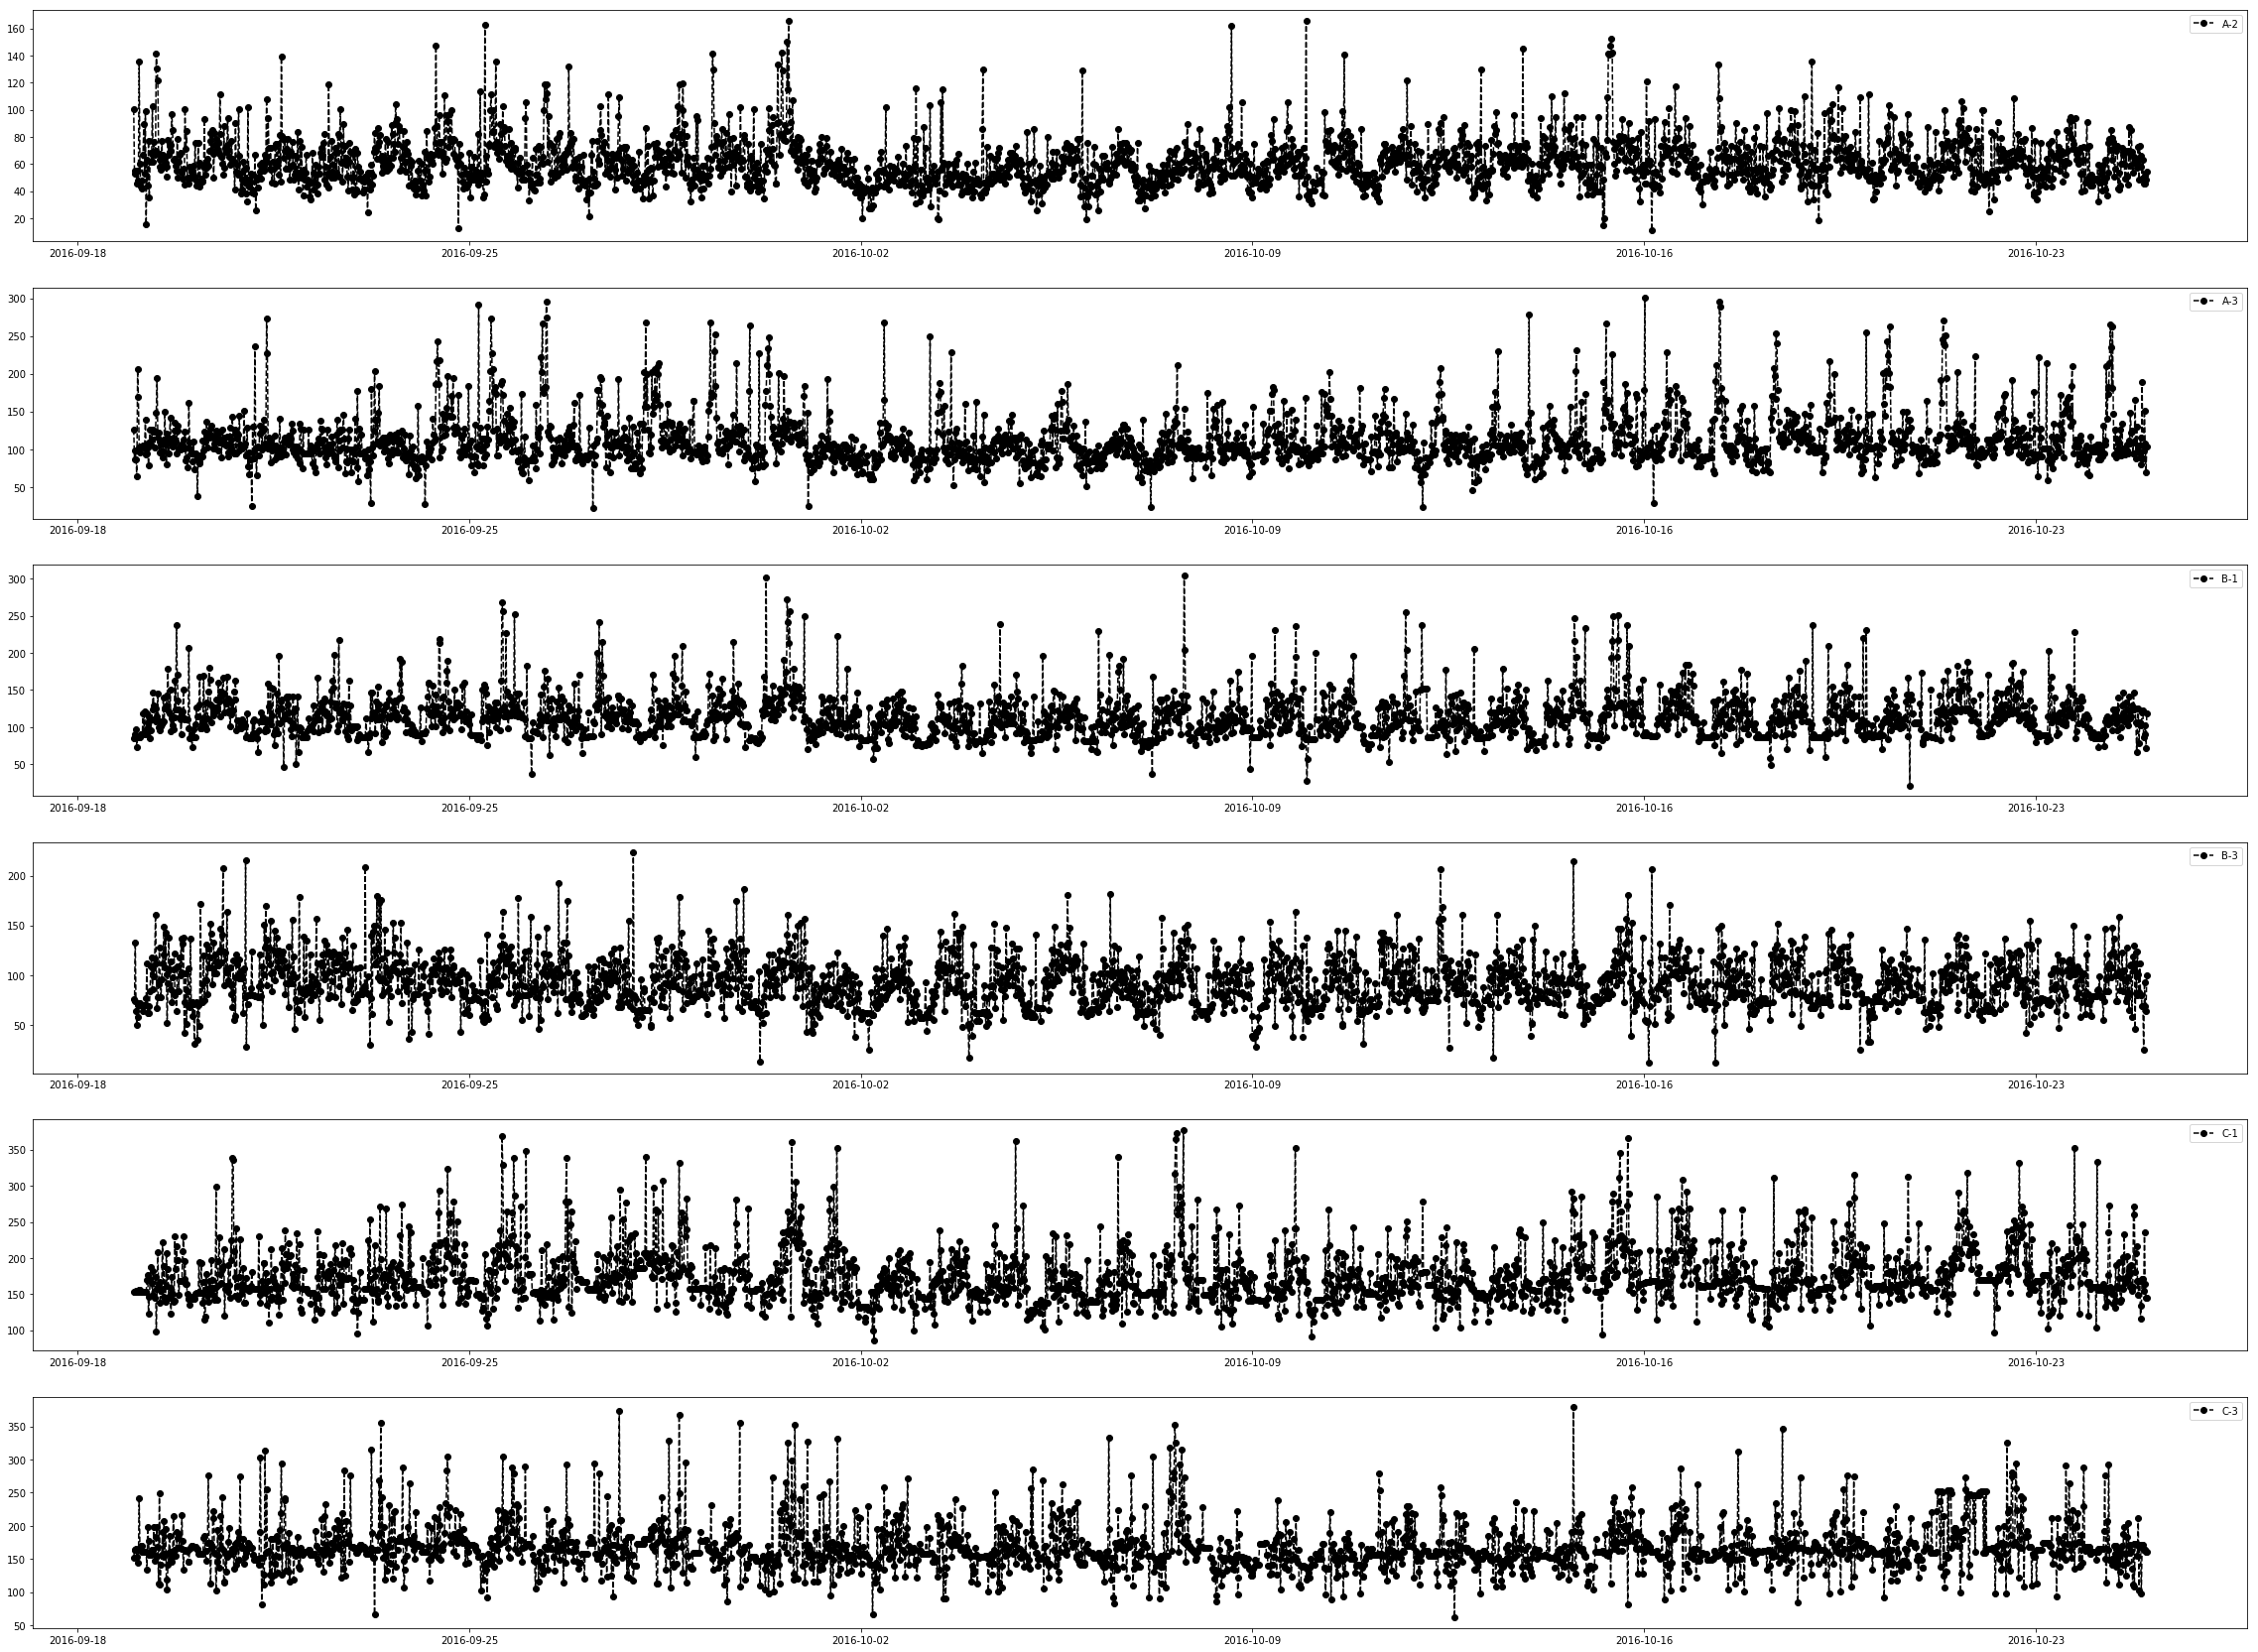

In [56]:
grouped_by_route = travel_time_window.groupby(['route'])
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(40)
k = 1
for k1, group in grouped_by_route:  
    ax = fig.add_subplot(6,1,k)
    k += 1
    ax.plot(group['start_time'], group['avg_travel_time'],'ko--', label=k1)
    ax.legend()

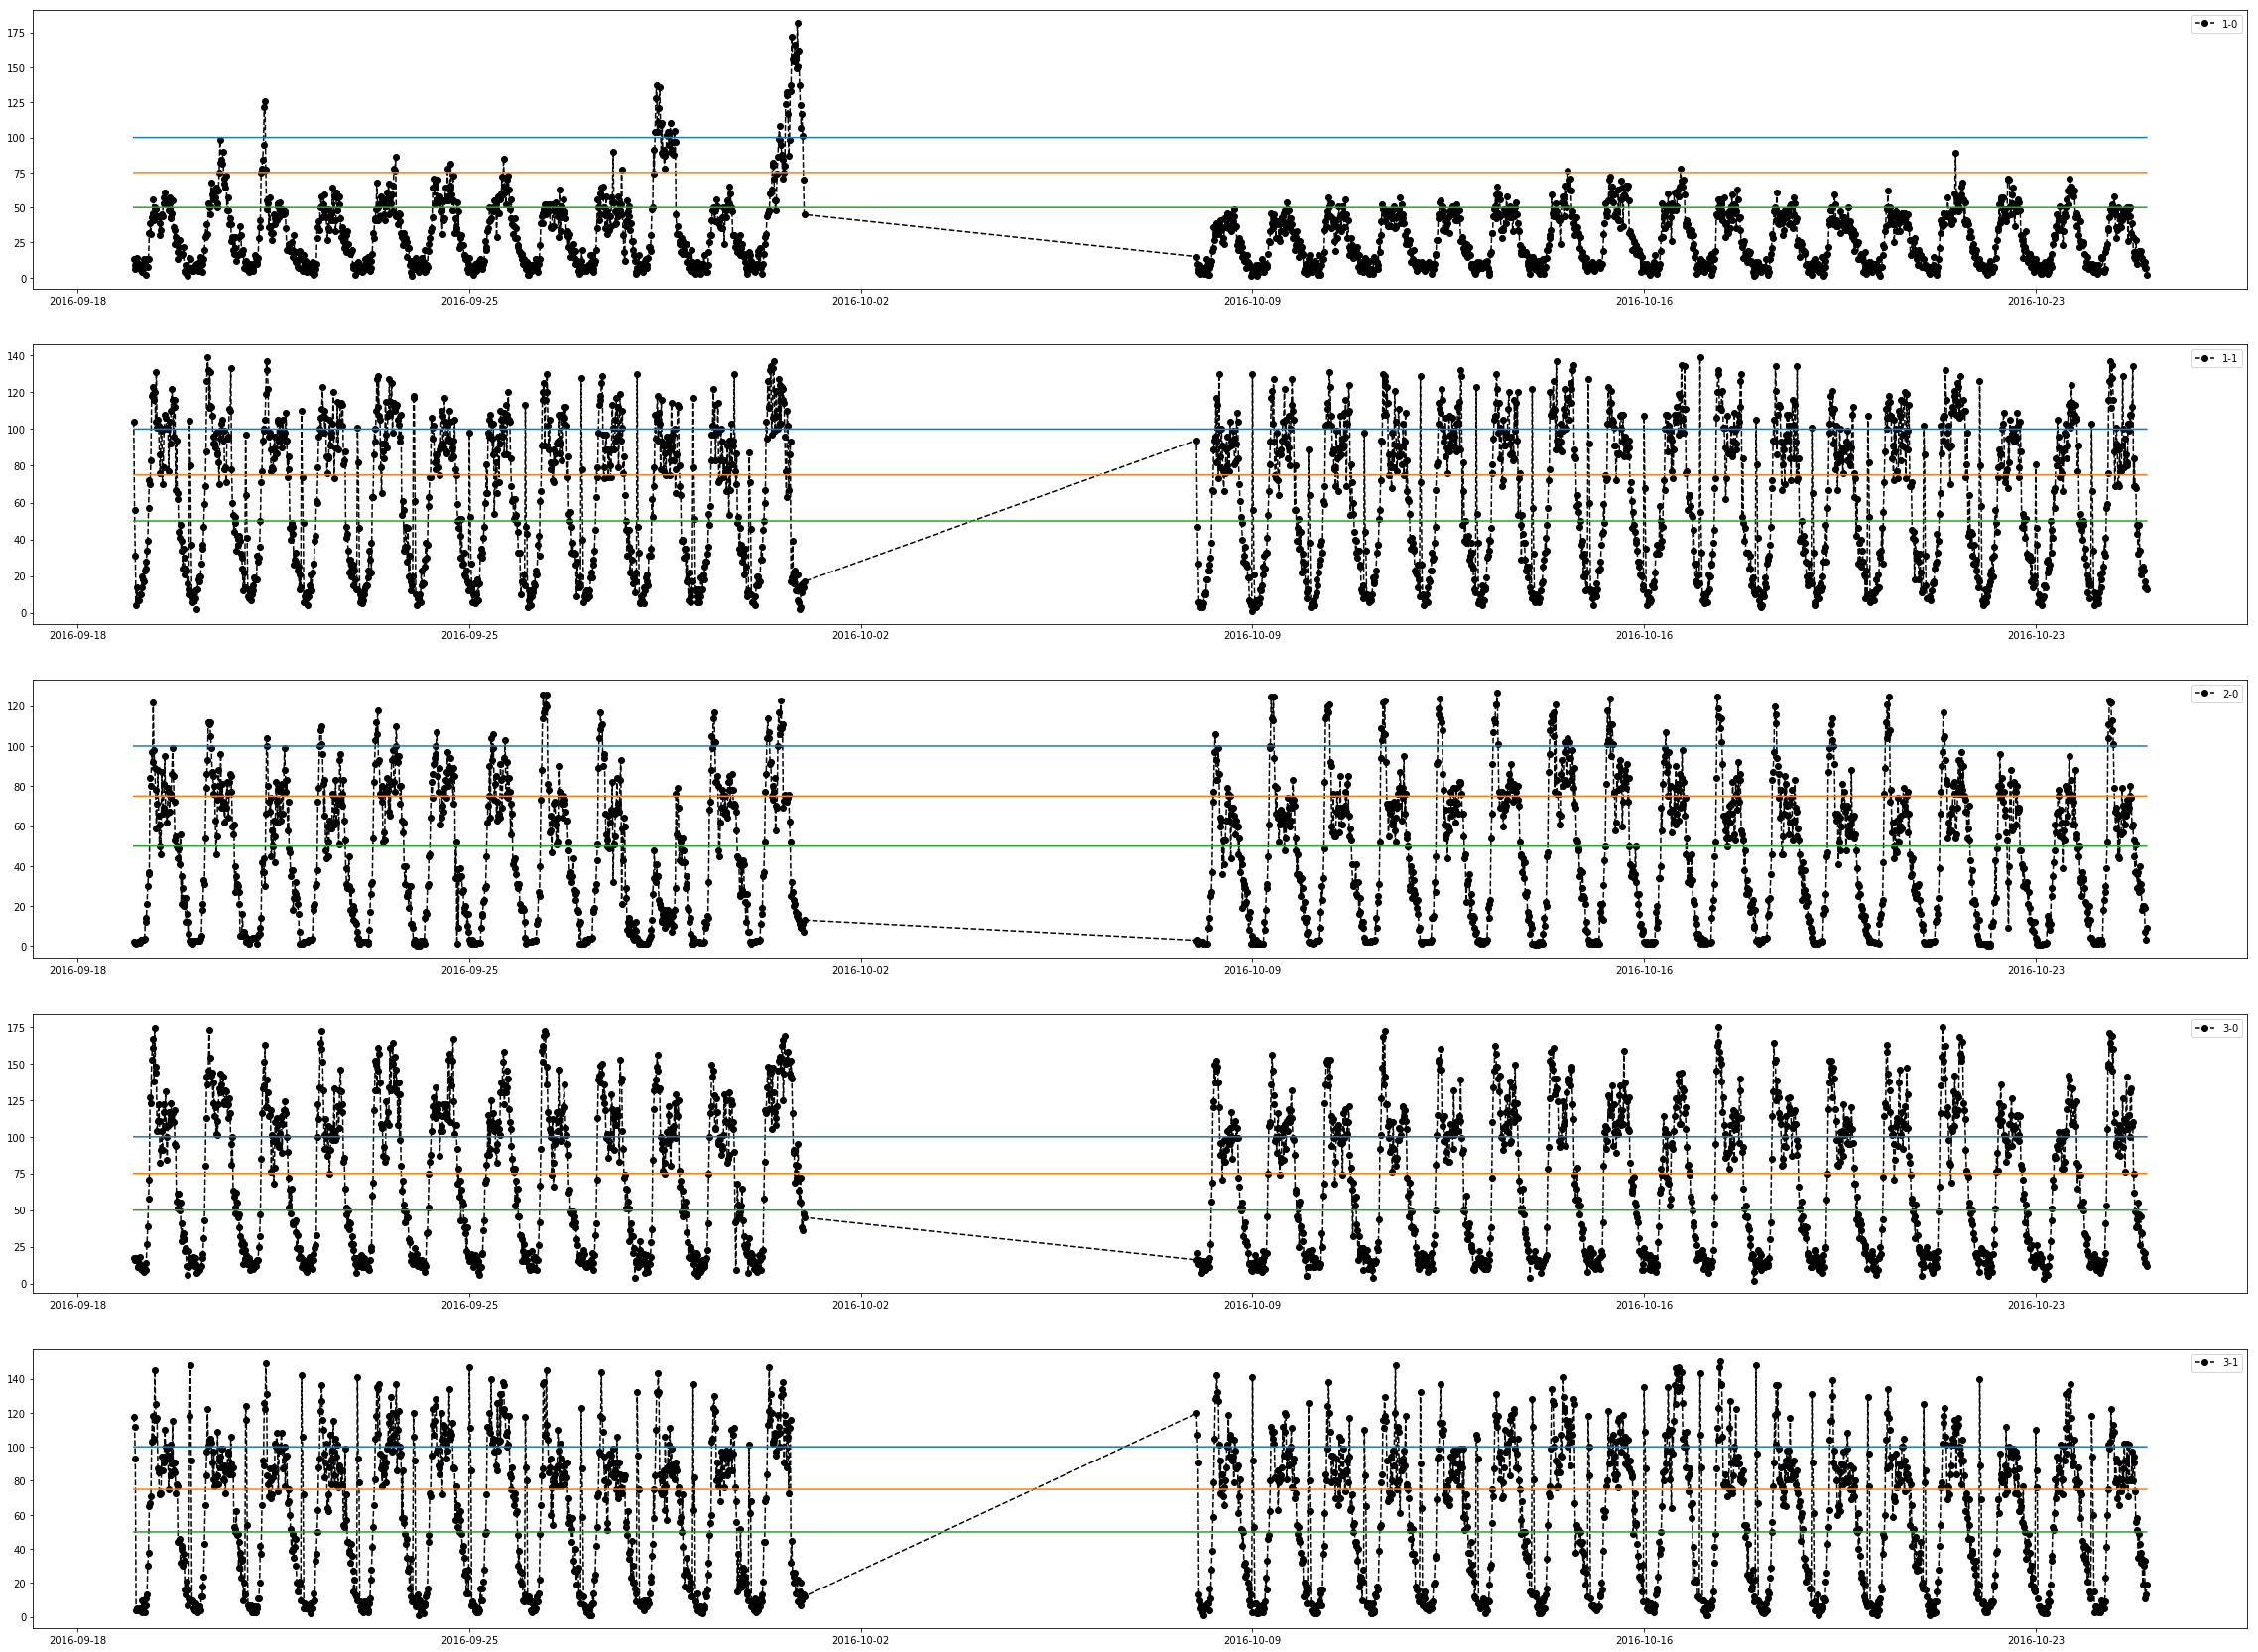

In [57]:
grouped_by_pair = volume_window.groupby(['pair'])
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(40)
k = 1
for k1, group in grouped_by_pair:  
    ax = fig.add_subplot(5,1,k)
    k += 1
    ax.plot(group['start_time'], group['volume'],'ko--', label=k1)
    ax.plot(group['start_time'], 100*np.ones(len(group)))
    ax.plot(group['start_time'], 75*np.ones(len(group)))
    ax.plot(group['start_time'], 50*np.ones(len(group)))
    ax.legend()

### 分割，只留9.19之后的数据

In [58]:
# 只取9.19之后的数据
start_date = date(2016,9,19)
travel_time_window = travel_time_window[travel_time_window['date'] >= start_date]

### 测试集先导信息缺失值补充（以均值补充）

In [59]:
# 测试集均值补充
submission_travel_time = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_submission/day1/travel_time_submission.csv')
submission_volume = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_submission/day1/volume_submission.csv')

In [60]:
test_travel_time_window['start_time'] = test_travel_time_window['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
for_test_time = submission_travel_time.copy()
del for_test_time['avg_travel_time']
for_test_time['start_time'] = for_test_time['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S')-timedelta(hours=2))
for_test_time['time_window'] = for_test_time['start_time'].map(lambda x: '[' + str(x) + ',' + str(x+timedelta(minutes=20)) + ')')
test_travel_time_window = pd.merge(for_test_time, test_travel_time_window, on=['intersection_id', 'tollgate_id', 'start_time', 'time_window'], how='outer')

In [61]:
# 先填充6,7,15,16点的

# 获取测试集时间段均值
time_for_mean = travel_time_window.copy()

# 留下目标时间段数据
time_for_mean = time_for_mean[['avg_travel_time', 'route', 'weekday', 'time', 'hour']]

time_for_mean = time_for_mean[(time_for_mean['hour']==6) | (time_for_mean['hour']==7) | 
                              (time_for_mean['hour']==15) | (time_for_mean['hour']==16)]

del time_for_mean['hour']
# 排好序
time_for_mean = time_for_mean.sort_values(by=['route', 'weekday', 'time'])

# 求好均值
time_group = time_for_mean.groupby(['route', 'weekday', 'time'])
mean_values = time_group.mean().values

# 补充
test_travel_time_window['weekday'] = test_travel_time_window['start_time'].map(lambda x: x.weekday())

test_travel_time_window = test_travel_time_window.sort_values(by=['intersection_id','tollgate_id','weekday','start_time'])
test_travel_time_window.index = np.arange(len(test_travel_time_window))

for k in range(len(test_travel_time_window)):
    if not (test_travel_time_window.ix[k,'avg_travel_time'] > 0):
        test_travel_time_window.ix[k,'avg_travel_time'] = mean_values[k]

del test_travel_time_window['weekday']
test_travel_time_window = test_travel_time_window.sort_values(by=['intersection_id', 'tollgate_id', 'start_time'])
test_travel_time_window.index = np.arange(len(test_travel_time_window))

In [62]:
# 留下目标时间段数据
time_for_mean = travel_time_window.copy()
volume_for_mean = volume_window.copy()

time_for_mean = time_for_mean[['avg_travel_time', 'route', 'weekday', 'time', 'hour']]
volume_for_mean = volume_for_mean[['volume', 'pair', 'weekday', 'time', 'hour']]

time_for_mean = time_for_mean[(time_for_mean['hour']==8) | (time_for_mean['hour']==9) | 
                              (time_for_mean['hour']==17) | (time_for_mean['hour']==18)]

volume_for_mean = volume_for_mean[(volume_for_mean['hour']==8) | (volume_for_mean['hour']==9) | 
                                  (volume_for_mean['hour']==17) | (volume_for_mean['hour']==18)]

del time_for_mean['hour']
del volume_for_mean['hour']
# 排好序
time_for_mean = time_for_mean.sort_values(by=['route', 'weekday', 'time'])
volume_for_mean = volume_for_mean.sort_values(by=['pair', 'weekday', 'time'])

# 求好均值
time_group = time_for_mean.groupby(['route', 'weekday', 'time'])
mean_values = time_group.mean().values

# 补充

submission_travel_time['start_time'] = submission_travel_time['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
submission_travel_time['weekday'] = submission_travel_time['start_time'].map(lambda x: x.weekday())
submission_travel_time = submission_travel_time.sort_values(by=['intersection_id','tollgate_id','weekday','start_time'])
submission_travel_time.index = np.arange(len(submission_travel_time))
submission_travel_time['avg_travel_time'] = mean_values

# 排序
submission_travel_time = submission_travel_time.sort_values(by=['intersection_id','tollgate_id','start_time'])
submission_travel_time.index = np.arange(len(submission_travel_time))

# 求好均值
volume_group = volume_for_mean.groupby(['pair', 'weekday', 'time'])
mean_values = volume_group.mean().values

# 补充
submission_volume['start_time'] = submission_volume['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
submission_volume['weekday'] = submission_volume['start_time'].map(lambda x: x.weekday())
submission_volume = submission_volume.sort_values(by=['tollgate_id','direction','weekday','start_time'])
submission_volume.index = np.arange(len(submission_volume))
submission_volume['volume'] = mean_values

# 排序
submission_volume = submission_volume.sort_values(by=['tollgate_id','direction','start_time'])
submission_volume.index = np.arange(len(submission_volume))

### 补充测试集特征

In [63]:
travel_time_window.columns

Index(['avg_travel_time', 'is_true', 'route', 'intersection_id', 'tollgate_id',
       'time_window', 'start_time', 'date', 'month', 'day', 'weekday',
       'holiday', 'time', 'hour', 'minute', 'timemap', 'pressure',
       'sea_pressure', 'wind_direction', 'wind_speed', 'temperature',
       'rel_humidity', 'precipitation'],
      dtype='object')

In [64]:
volume_window.columns

Index(['volume', 'is_true', 'pair', 'tollgate_id', 'direction', 'time_window',
       'start_time', 'date', 'month', 'day', 'weekday', 'holiday', 'time',
       'hour', 'minute', 'timemap', 'pressure', 'sea_pressure',
       'wind_direction', 'wind_speed', 'temperature', 'rel_humidity',
       'precipitation'],
      dtype='object')

In [65]:
submission_travel_time.columns

Index(['intersection_id', 'tollgate_id', 'time_window', 'avg_travel_time',
       'start_time', 'weekday'],
      dtype='object')

In [66]:
submission_volume.columns

Index(['tollgate_id', 'time_window', 'direction', 'volume', 'start_time',
       'weekday'],
      dtype='object')

In [67]:
# 天气特征
test_weather_data['hour'] = test_weather_data['hour'].map(lambda x: ' ' + time(x, 0, 0).strftime('%H:%M:%S'))
test_weather_data['start_time'] = test_weather_data['date'] + test_weather_data['hour']
test_weather_data['start_time'] = test_weather_data['start_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
del test_weather_data['date']
del test_weather_data['hour']
num = len(test_weather_data)
for i in range(num):
    temp = test_weather_data.ix[i]
    temp1 = copy.deepcopy(temp)
    temp2 = copy.deepcopy(temp)
    temp3 = copy.deepcopy(temp)
    temp4 = copy.deepcopy(temp)
    temp5 = copy.deepcopy(temp)
    temp6 = copy.deepcopy(temp)
    temp7 = copy.deepcopy(temp)
    temp8 = copy.deepcopy(temp)
    stime = temp.start_time
    temp1.start_time = stime + timedelta(minutes=20)
    temp2.start_time = stime + timedelta(minutes=40)
    temp3.start_time = stime + timedelta(minutes=60)
    temp4.start_time = stime + timedelta(minutes=80)
    temp5.start_time = stime + timedelta(minutes=100)
    temp6.start_time = stime + timedelta(minutes=120)
    temp7.start_time = stime + timedelta(minutes=140)
    temp8.start_time = stime + timedelta(minutes=160)
    alltemp = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
    alltemp = pd.DataFrame(alltemp)
    test_weather_data = pd.concat([test_weather_data, alltemp])

In [68]:
submission_travel_time = submission_travel_time.sort_values(by = ['intersection_id', 'tollgate_id', 'start_time'])
submission_travel_time.index = np.arange(len(submission_travel_time))

submission_travel_time = pd.merge(submission_travel_time, test_weather_data, on='start_time', how='left')
submission_travel_time['date'] = submission_travel_time['start_time'].map(lambda x: x.date())
submission_travel_time['time'] = submission_travel_time['start_time'].map(lambda x: x.time())
submission_travel_time['hour'] = submission_travel_time['start_time'].map(lambda x: x.hour)
submission_travel_time['minute'] = submission_travel_time['start_time'].map(lambda x: x.minute)

In [69]:
# weekday特征
submission_travel_time['weekday'] = submission_travel_time['start_time'].map(lambda x: x.weekday())
# route特征
submission_travel_time['route'] = submission_travel_time['intersection_id'].astype(str) + '-' + submission_travel_time['tollgate_id'].astype(str)

In [70]:
submission_travel_time['last_20min'] = 0
# last_20min
for i in range(len(submission_travel_time)):
    if (i % 6) == 0:
        submission_travel_time.ix[i,'last_20min'] = test_travel_time_window.ix[i+5,'avg_travel_time']
    else:
        submission_travel_time.ix[i,'last_20min'] = submission_travel_time.ix[i-1,'avg_travel_time']

In [71]:
# 把time映射成1～72
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
submission_travel_time['timemap'] = submission_travel_time['time'].map(lambda x:timedic[x])

In [72]:
submission_volume = submission_volume.sort(['tollgate_id', 'direction', 'start_time'])
# pair特征
submission_volume['pair'] = submission_volume['tollgate_id'].astype(str) + '-' + submission_volume['direction'].astype(str)

# 天气特征
submission_volume = pd.merge(submission_volume, test_weather_data, on='start_time', how='left')

# 星期几
submission_volume['weekday'] = submission_volume['start_time'].map(lambda x: x.weekday())

# 时间窗口
submission_volume['time'] = submission_volume['start_time'].map(lambda x: x.time())
submission_volume['date'] = submission_volume['start_time'].map(lambda x: x.date())

submission_volume['hour'] = submission_volume['start_time'].map(lambda x: x.hour)
submission_volume['minute'] = submission_volume['start_time'].map(lambda x: x.minute)

/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [73]:
# last_20min
submission_volume['last_20min'] = 0
# last_20min
for i in range(len(submission_volume)):
    if (i % 6) == 0:
        submission_volume.ix[i,'last_20min'] = test_volume_window.ix[i+5,'volume']
    else:
        submission_volume.ix[i,'last_20min'] = submission_volume.ix[i-1,'volume']

In [74]:
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
submission_volume['timemap'] = submission_volume['time'].map(lambda x:timedic[x])

### 补充下训练集的last_20min

In [75]:
travel_time_window = travel_time_window.sort_values(by = ['intersection_id', 'tollgate_id', 'start_time'])
travel_time_window.index = np.arange(len(travel_time_window))

volume_window = volume_window.sort_values(by = ['tollgate_id', 'direction', 'start_time'])
volume_window.index = np.arange(len(volume_window))

In [76]:
travel_time_window['last_20min'] = np.nan
volume_window['last_20min'] = np.nan

start_time = datetime(2016,9,19,0,0,0)

for i in range(0,len(travel_time_window)):
    if travel_time_window.ix[i,'start_time'] != start_time:
        travel_time_window.ix[i,'last_20min'] = travel_time_window.ix[i-1,'avg_travel_time']

for i in range(0,len(volume_window)):
    if volume_window.ix[i,'start_time'] != start_time:
        volume_window.ix[i,'last_20min'] = volume_window.ix[i-1,'volume']

In [77]:
travel_time_window = travel_time_window.fillna(method='bfill')
volume_window = volume_window.fillna(method='bfill')

### 选择特征输出

In [78]:
submission_travel_time['month'] = submission_travel_time['date'].map(lambda x: x.month)
submission_travel_time['day'] = submission_travel_time['date'].map(lambda x: x.day)
submission_travel_time['holiday'] = 0

submission_volume['month'] = submission_volume['date'].map(lambda x: x.month)
submission_volume['day'] = submission_volume['date'].map(lambda x: x.day)
submission_volume['holiday'] = 0

In [79]:
time_columns = ['route', 'intersection_id', 'tollgate_id',
                'time_window', 'start_time', 'date', 'month', 'day', 'weekday',
                'holiday', 'time', 'hour', 'minute', 'timemap', 'pressure',
                'sea_pressure', 'wind_direction', 'wind_speed', 'temperature',
                'rel_humidity', 'precipitation', 'last_20min']
volume_columns = ['pair', 'tollgate_id', 'direction', 'time_window',
                  'start_time', 'date', 'month', 'day', 'weekday', 'holiday', 'time',
                  'hour', 'minute', 'timemap', 'pressure', 'sea_pressure',
                  'wind_direction', 'wind_speed', 'temperature', 'rel_humidity',
                  'precipitation', 'last_20min']

In [80]:
submission_travel_time = submission_travel_time[time_columns]
submission_volume = submission_volume[volume_columns]

In [82]:
# 输出
travel_time_window.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/travel_time_train_data.csv', index=False)
volume_window.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/volume_train_data.csv', index=False)

submission_travel_time.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/test_travel_time_data.csv', index=False)
submission_volume.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/test_volume_data.csv', index=False)

### 形成交叉特征

In [83]:
temp = travel_time_window.groupby('start_time')['avg_travel_time']

def ff(group):
    return group['avg_travel_time'].values.T

temp_values = travel_time_window.groupby('start_time').apply(ff)

time_cross_feature = pd.DataFrame(temp_values)
time_cross_feature.columns = ['set']

time_cross_feature['start_time'] = time_cross_feature.index
time_cross_feature['A-2'] = time_cross_feature['set'].map(lambda x: x[0])
time_cross_feature['A-3'] = time_cross_feature['set'].map(lambda x: x[1])
time_cross_feature['B-1'] = time_cross_feature['set'].map(lambda x: x[2])
time_cross_feature['B-3'] = time_cross_feature['set'].map(lambda x: x[3])
time_cross_feature['C-1'] = time_cross_feature['set'].map(lambda x: x[4])
time_cross_feature['C-3'] = time_cross_feature['set'].map(lambda x: x[5])
del time_cross_feature['set']

In [84]:
temp = volume_window.groupby('start_time')['volume']

def ff(group):
    return group['volume'].values.T

temp_values = volume_window.groupby('start_time').apply(ff)

volume_cross_feature = pd.DataFrame(temp_values)
volume_cross_feature.columns = ['set']

volume_cross_feature['start_time'] = volume_cross_feature.index
volume_cross_feature['1-0'] = volume_cross_feature['set'].map(lambda x: x[0])
volume_cross_feature['1-1'] = volume_cross_feature['set'].map(lambda x: x[1])
volume_cross_feature['2-0'] = volume_cross_feature['set'].map(lambda x: x[2])
volume_cross_feature['3-0'] = volume_cross_feature['set'].map(lambda x: x[3])
volume_cross_feature['3-1'] = volume_cross_feature['set'].map(lambda x: x[4])
del volume_cross_feature['set']

In [85]:
cross_feature = pd.merge(time_cross_feature, volume_cross_feature, on=['start_time'])

cross_feature.columns = ['start_time', 'last_20min_A2', 'last_20min_A3', 'last_20min_B1', 'last_20min_B3'
                        , 'last_20min_C1', 'last_20min_C3', 'last_20min_V10', 'last_20min_V11', 'last_20min_V20'
                        , 'last_20min_V30', 'last_20min_V31']

cross_feature['start_time'] = cross_feature['start_time'].map(lambda x: x+timedelta(minutes=20))

travel_time_window = pd.merge(travel_time_window, cross_feature, on='start_time', how='left')
volume_window = pd.merge(volume_window, cross_feature, on='start_time', how='left')

travel_time_window = travel_time_window.fillna(method='bfill')
volume_window = volume_window.fillna(method='bfill')

In [86]:
# 测试集的交叉特征

In [87]:
time__mean = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/submission_result/phase2.0/Mean/travel_time_submission.csv')
volume__mean = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/submission_result/phase2.0/Mean/volume_submission.csv')

In [88]:
test_travel_time_temp = test_travel_time_window.copy()
test_volume_temp = test_volume_window.copy()

In [89]:
time__mean['start_time'] = time__mean['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
volume__mean['start_time'] = volume__mean['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))

test_volume_temp['start_time'] = test_volume_temp['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))

time__mean = time__mean[['intersection_id', 'tollgate_id', 'time_window', 'start_time', 'avg_travel_time']]
volume__mean = volume__mean[['tollgate_id', 'time_window', 'direction', 'start_time', 'volume']]

test_travel_time_temp = test_travel_time_temp[['intersection_id', 'tollgate_id', 'time_window', 'start_time', 'avg_travel_time']]
test_volume_temp = test_volume_temp[['tollgate_id', 'time_window', 'direction', 'start_time', 'volume']]

In [90]:
test_full_time_window = pd.concat([time__mean, test_travel_time_temp], axis=0)
test_full_volume_window = pd.concat([volume__mean, test_volume_temp], axis=0)

In [91]:
test_full_time_window['time'] = test_full_time_window['start_time'].map(lambda x: x.time())
test_full_volume_window['time'] = test_full_volume_window['start_time'].map(lambda x: x.time())

In [92]:
start_time1 = time(7,40,0)
end_time1 = time(9,20,0)
start_time2 = time(16,40,0)
end_time2 = time(18,20,0)

temp1 = test_full_time_window[((test_full_time_window['time']>=start_time1) & (test_full_time_window['time']<=end_time1))
                              | ((test_full_time_window['time']>=start_time2) & (test_full_time_window['time']<=end_time2))
                             ]

temp2 = test_full_volume_window[((test_full_volume_window['time']>=start_time1) & (test_full_volume_window['time']<=end_time1))
                              | ((test_full_volume_window['time']>=start_time2) & (test_full_volume_window['time']<=end_time2))
                             ]

In [93]:
temp1 = temp1.sort_values(by=['intersection_id','tollgate_id','start_time'])
temp1.index = np.arange(len(temp1))
temp2 = temp2.sort_values(by=['tollgate_id','direction','start_time'])
temp2.index = np.arange(len(temp2))

In [94]:
temp1['start_time'] = temp1['start_time'].map(lambda x: x+timedelta(minutes=20))
temp2['start_time'] = temp2['start_time'].map(lambda x: x+timedelta(minutes=20))

In [95]:
def ff(group):
    return group['avg_travel_time'].values.T

temp_values = temp1.groupby('start_time').apply(ff)

time_cross_feature = pd.DataFrame(temp_values)
time_cross_feature.columns = ['set']

time_cross_feature['start_time'] = time_cross_feature.index
time_cross_feature['A-2'] = time_cross_feature['set'].map(lambda x: x[0])
time_cross_feature['A-3'] = time_cross_feature['set'].map(lambda x: x[1])
time_cross_feature['B-1'] = time_cross_feature['set'].map(lambda x: x[2])
time_cross_feature['B-3'] = time_cross_feature['set'].map(lambda x: x[3])
time_cross_feature['C-1'] = time_cross_feature['set'].map(lambda x: x[4])
time_cross_feature['C-3'] = time_cross_feature['set'].map(lambda x: x[5])
del time_cross_feature['set']

In [96]:
def ff(group):
    return group['volume'].values.T

temp_values = temp2.groupby('start_time').apply(ff)

volume_cross_feature = pd.DataFrame(temp_values)
volume_cross_feature.columns = ['set']

volume_cross_feature['start_time'] = volume_cross_feature.index
volume_cross_feature['1-0'] = volume_cross_feature['set'].map(lambda x: x[0])
volume_cross_feature['1-1'] = volume_cross_feature['set'].map(lambda x: x[1])
volume_cross_feature['2-0'] = volume_cross_feature['set'].map(lambda x: x[2])
volume_cross_feature['3-0'] = volume_cross_feature['set'].map(lambda x: x[3])
volume_cross_feature['3-1'] = volume_cross_feature['set'].map(lambda x: x[4])
del volume_cross_feature['set']

In [97]:
cross_feature = pd.merge(time_cross_feature, volume_cross_feature, on=['start_time'])

cross_feature.columns = ['start_time', 'last_20min_A2', 'last_20min_A3', 'last_20min_B1', 'last_20min_B3'
                        , 'last_20min_C1', 'last_20min_C3', 'last_20min_V10', 'last_20min_V11', 'last_20min_V20'
                        , 'last_20min_V30', 'last_20min_V31']

haha1 = pd.merge(submission_travel_time, cross_feature, on='start_time', how='left')
haha2 = pd.merge(submission_volume, cross_feature, on='start_time', how='left')

In [98]:
# 输出
travel_time_window.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/travel_time_train_data.csv', index=False)
volume_window.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/volume_train_data.csv', index=False)

haha1.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/test_travel_time_data.csv', index=False)
haha2.to_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/加工好的数据/7.75/test_volume_data.csv', index=False)